In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, layers, optimizers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [ ]:
CSV_PATH = './../data/GOOGL.csv'
DATE_COL = 'Date'

SEQ_LENGTH = 60
BATCH_SIZE = 32
LEARNING_RATE = 0.1
EPOCHS = 60

# FEATURES = [
#     'Open', 'High', 'Low', 'Close', 'Volume',
#     'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
#     'BBL_20_2.0_2.0','BBM_20_2.0_2.0','BBU_20_2.0_2.0','BBB_20_2.0_2.0','BBP_20_2.0_2.0',
#     'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
# ]

FEATURES = [
    'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
]

TARGET = 'direction'

TRAINING_RANGE = ('2010-01-01', '2024-12-31')
TESTING_RANGE = ('2025-01-01', '2025-10-22')

In [63]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [64]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df = df[[DATE_COL] + FEATURES + [TARGET]]
df.dropna(inplace=True)

feature_scaler = StandardScaler()#MinMaxScaler()

feature_data = feature_scaler.fit_transform(df[FEATURES])
target_data = df[[TARGET]].values

print(tb.tabulate(feature_data[:5], headers=FEATURES, tablefmt='psql'))
print(tb.tabulate(target_data[:5], headers=[TARGET], tablefmt='psql'))

+---------+----------------+-----------------+-----------------+-----------+-----------+-----------+-----------+-----------+-----------+
|     rsi |   MACD_12_26_9 |   MACDh_12_26_9 |   MACDs_12_26_9 |    ema_10 |    ema_20 |    ema_50 |       atr |   stoch_k |   stoch_d |
|---------+----------------+-----------------+-----------------+-----------+-----------+-----------+-----------+-----------+-----------|
| 2.26036 |      0.069751  |        0.240104 |      0.00367968 | -0.933339 | -0.942117 | -0.960079 | -0.758485 |   1.08159 |   1.02797 |
| 2.02674 |      0.0807454 |        0.222327 |      0.0204574  | -0.931558 | -0.940525 | -0.958869 | -0.757412 |   1.16055 |   1.10351 |
| 2.14373 |      0.0930748 |        0.211974 |      0.0364814  | -0.929636 | -0.93884  | -0.957604 | -0.759417 |   1.2486  |   1.20006 |
| 2.03773 |      0.0978294 |        0.181734 |      0.050304   | -0.928164 | -0.937368 | -0.95641  | -0.76273  |   1.17295 |   1.23147 |
| 1.7423  |      0.0939541 |        0.132

In [65]:
X, y = [], []
dates = []
for i in range(SEQ_LENGTH, len(feature_data)):
    tmp = feature_data[i - SEQ_LENGTH:i]
    X.append(tmp)
    dates.append(df[DATE_COL].values[i])
    y.append(target_data[i])

X, y = np.array(X), np.array(y)

print(f"Feature data shape: {X.shape}")
print(f"Target data shape: {y.shape}")

Feature data shape: (5219, 60, 10)
Target data shape: (5219, 1)


In [66]:
def find_closest_date_index(dates_array, target_date):
    target_date = np.datetime64(target_date)
    index = np.argmin(np.abs(dates_array - target_date))
    return index

train_beg, train_end = find_closest_date_index(dates, TRAINING_RANGE[0]), find_closest_date_index(dates, TRAINING_RANGE[1])
test_beg, test_end = find_closest_date_index(dates, TESTING_RANGE[0]), find_closest_date_index(dates, TESTING_RANGE[1])

print(f"Training: beg_idx={train_beg} -> beg={dates[train_beg]} || end_idx={train_end} -> end={dates[train_end]}")
print(f"Testing:  beg_idx={test_beg} -> beg={dates[test_beg]} || end_idx={test_end} -> end={dates[test_end]}")

X_train, y_train = X[train_beg:train_end+1], y[train_beg:train_end+1]
X_test, y_test = X[test_beg:test_end+1], y[test_beg:test_end+1]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training: beg_idx=1243 -> beg=2009-12-31T00:00:00.000000000 || end_idx=5017 -> end=2024-12-31T00:00:00.000000000
Testing:  beg_idx=5017 -> beg=2024-12-31T00:00:00.000000000 || end_idx=5218 -> end=2025-10-21T00:00:00.000000000
X_train shape: (3775, 60, 10), y_train shape: (3775, 1)
X_test shape: (202, 60, 10), y_test shape: (202, 1)


In [ ]:
def create_financial_model(seq_length, feature_count, learning_rate):
    inputs = layers.Input(shape=(seq_length, feature_count))

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2))(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.LayerNormalization()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model


model = create_financial_model(SEQ_LENGTH, len(FEATURES), LEARNING_RATE)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 96)         │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,049 (820.50 KB)

 Trainable params: 210,049 (820.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5158 - loss: 0.6974 - precision_5: 0.5308 - recall_5: 0.7369 - learning_rate: 0.0100
Epoch 2/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5245 - loss: 0.6935 - precision_5: 0.5290 - recall_5: 0.9315 - learning_rate: 0.0100
Epoch 3/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5295 - loss: 0.6917 - precision_5: 0.5295 - recall_5: 1.0000 - learning_rate: 0.0100
Epoch 4/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5295 - loss: 0.6916 - precision_5: 0.5295 - recall_5: 1.0000 - learning_rate: 0.0100
Epoch 5/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5295 - loss: 0.6916 - precision_5: 0.5295 - recall_5: 1.0000 - learning_rate: 0.0100
Epoch 6/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5295 - loss: 0.6917 - precision_5: 0.5295 - recall_5: 1.0000 - learning_rate: 0.0100
Epoch 7/60
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5295 - loss: 0.6916 -

In [ ]:
pred_probs = model.predict(X_test)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
y_true = y_test.flatten()

acc = accuracy_score(y_true, pred_labels)
prec = precision_score(y_true, pred_labels)
rec = recall_score(y_true, pred_labels)
f1 = f1_score(y_true, pred_labels)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_true, pred_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Accuracy:  0.600
Precision: 0.600
Recall:    1.000
F1 Score:  0.750
Confusion Matrix:
[[0 6]
 [0 9]]


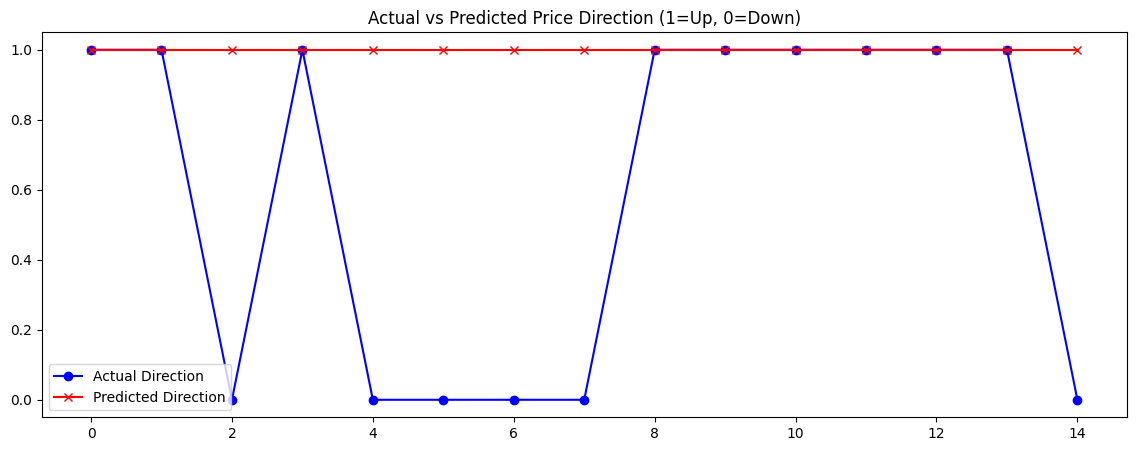

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_true, label='Actual Direction', color='blue', marker='o')
plt.plot(pred_labels, label='Predicted Direction', color='red', marker='x')
plt.title('Actual vs Predicted Price Direction (1=Up, 0=Down)')
plt.legend()
plt.show()